# Outline

[1. Establishing Goals](#1.-Establishing-Goals)

[2. Introduction to Dataset](#2.-Introduction-to-Dataset)

[3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)

[4. Limit Data to Scope](#4.-Limit-Data-to-Scope)

[5. Supervised Feature Generation](#5.-Supervised-Feature-Generation)
    
- [5.1 Common Bag of Words](#5.1-Common-Bag-of-Words)
- [5.2 Turn Common Words into Features](#5.2-Turn-Common-Words-into-Features)
- [5.3 Clustering on BOW](#5.3.-Clustering-on-BOW)
- [5.4 Classification on BOW](#5.4.-Classification-on-BOW)

[6. Unsupervised Feature Generation](#6.-Unsupervised-Feature-Generation)

- [6.1 Latent Semantic Analysis](#6.1.-Latent-Semantic-Analysis)
- [6.2 Clustering on LSA (BOW Content)](#6.2.-Clustering-on-LSA-(BOW-Content))
- [6.3 Classification on LSA (BOW Content)](#6.3.-Classification-on-LSA-(BOW-Content))
- [6.4 Clustering on LSA (All Content)](#6.4.-Clustering-on-LSA-(All-Content))
- [6.5 Classification on LSA (All Content)](#6.5.-Classification-on-LSA-(All-Content))

[7. Choosing Model](#7.-Choosing-Model)

- [7.1 Comparing Scores](#7.1.-Comparing-Scores)
- [7.2 Sorting by Test Accuracy](#7.2.-Sorting-by-Test_Accuracy)
- [7.3 Winner](#7.3.-Winner)

# 1. Establishing Goals

In this project I'll attempt to build models to correctly predict the author of a given article. The scope will be limited to 10 authors. The techniques I'll compare will include `Bag-of-Words` VS `Latent Semantic Analysis` for feature-generation, and `Clustering` VS `Supervised Learning` for classification. I'll also experiment with different sample sizes, as feature-generation can be very sensitive to high dimensionality.

# 2. Introduction to DataSet

**From:** https://www.kaggle.com/snapcrack/all-the-news

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title.

The original source on `kaggle.com` contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications. 

The dataset used here is only the first of those three files, which contains about a third of all the data at roughly `280MB`. This is more than enough data for the goals of this project.

# 3. Exploratory Data Analysis

Let's get a quick overview of the data available.

In [1]:
# General-purpose Libraries
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read data into a DataFrame
data = pd.read_csv("https://onedrive.live.com/download?cid=62B3CEE436FDB342&resid=62B3CEE436FDB342%21105&authkey=ALXS3pl3SIOHypY")

In [3]:
# Preview the data
data.head(3)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."


**Checking for Missing Data**

- The content feature is complete. That's the most important thing. Some author names are missing. We'll make sure to choose 10 properly labeled.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Unnamed: 0     50000 non-null int64
id             50000 non-null int64
title          50000 non-null object
publication    50000 non-null object
author         43694 non-null object
date           50000 non-null object
year           50000 non-null float64
month          50000 non-null float64
url            0 non-null float64
content        50000 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


**Length of Articles**
- In terms of number of characters, the average article has less than 4,000 letters.

Statistical Summary of Article Lengths
count     50000.0000
mean       3853.4537
std        3875.9117
min           1.0000
25%        1682.0000
50%        2853.0000
75%        5045.0000
max      149346.0000
dtype: float64


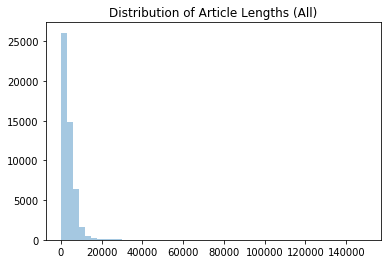

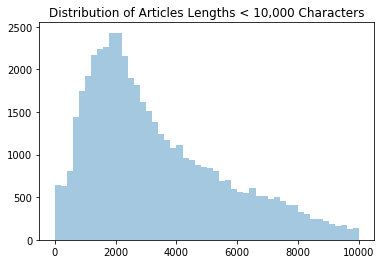

In [5]:
lengths = pd.Series([len(x) for x in data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

# 4. Limit Data to Scope
[Back to Outline](#Outline)

Here I'll pick the 10 authors whose names I'll predict based on their content. This selection will remain the same for all the methods I'll compare.

Since we only need 10 authors, I'll get the first 10 authors whose article-count is greater than X. 100 articles per author is a good number because more would take terribly long when fit to classifiers after `TF-IDF`. At the same time, `Bag-of-Words` is the slowest. However, for that I'll limit to 50 of these articles per author.

In [6]:
# First ten authors with more than X articles
print(data.author.value_counts()[data.author.value_counts()>100][-10:])

Scott Davis          119
Eugene Scott         118
Laura Smith-Spark    115
Julie Bort           110
Raheem Kassam        110
Jeremy Berke         109
Eli Watkins          106
Oliver Darcy         104
Daniella Diaz        104
Cartel Chronicles    102
Name: author, dtype: int64


In [7]:
# Make a DataFrame with articles by our chosen authors
# Include author names and article titles.

# Make a list of the 10 chosen author names
names = data.author.value_counts()[data.author.value_counts()>100][-10:].index.tolist()

# DataFrame for articles of all chosen authors
authors_data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = data[data.author==name][:100][['title','content','author']]
    # Append it to the DataFrame
    authors_data = authors_data.append(articles)

authors_data = authors_data.reset_index().drop('index',1)
    
authors_data.head()

,title,content,author
0,A scramble for quarterbacks in the 2016 NFL Dr...,’ ’ ’ Two NFL teams enter the postseason st...,Scott Davis
1,Rio’s Olympic Stadium has reportedly turned in...,’ ’ ” As is the case with many Rio’s Marac...,Scott Davis
2,The Grizzlies gambled on Chandler Parsons with...,’ ’ ’ Even in an NBA era with a rising sala...,Scott Davis
3,Kevin Love had some simple advice for the Cavs...,’ ’ ’ The Cleveland Cavaliers are with the...,Scott Davis
4,Aaron Rodgers completes another ridiculous Hai...,’ After a slow start to their Wild Card game...,Scott Davis


In [8]:
# Look for duplicates
print('Number of articles:',authors_data.shape[0])
print('Unique articles:',len(np.unique(authors_data.index)))

# Number of authors
print('Unique authors:',len(np.unique(authors_data.author)))
print('')
print('Articles by author:\n')

# Articles counts by author
print(authors_data.author.value_counts())

Number of articles: 1000
Unique articles: 1000
Unique authors: 10

Articles by author:

Oliver Darcy         100
Cartel Chronicles    100
Jeremy Berke         100
Daniella Diaz        100
Laura Smith-Spark    100
Eli Watkins          100
Eugene Scott         100
Raheem Kassam        100
Scott Davis          100
Julie Bort           100
Name: author, dtype: int64


**Look at the Size of Articles Chosen**

Statistical Summary of Article Lengths
count     1000.000000
mean      3004.200000
std       2608.965556
min        106.000000
25%       1645.000000
50%       2356.500000
75%       3522.500000
max      33798.000000
dtype: float64


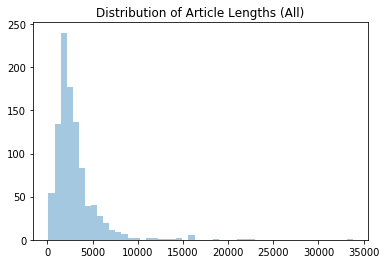

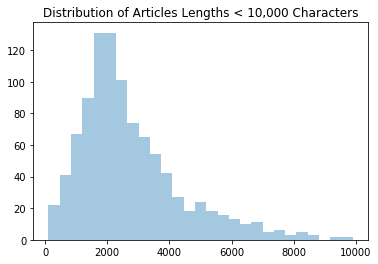

In [9]:
lengths = pd.Series([len(x) for x in authors_data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

# 5. Supervised Feature Generation
[Back to Outline](#Outline)

Bag of words is a list of the most common words of a given source of text. To identify each author, I'll create a bag of words containing the most-common words of all authors combined. This set later becomes the basis for feature engineering.

## 5.1 Common Bag of Words
- Here I'll extract the most-common 1000 words from each author's corpus, store them in a list, and then eliminate duplicates.

In [10]:
t0 = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store the spacy_doc object of each author
authors_docs = {}

for name in names:
    # Corpus is all the text written by that author
    corpus = ""
    # Grab all rows of current author, along the 'content' column
    author_content = authors_data.loc[authors_data.author==name,'content']
    
    # Merge all articles in to the author's corpus
    for article in author_content:
        corpus = corpus + article
    # Let Spacy parse the author's body of text
    doc = nlp(corpus)
    
    # Store the doc in the dictionary
    authors_docs[name] = doc
        
    # Filter out punctuation and stop words.
    lemmas = [token.lemma_ for token in doc
                if not token.is_punct and not token.is_stop]
        
    # Return the most common words of that author's corpus.
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of words by all authors.
    for word in bow:
        common_words.append(word)

# Eliminate duplicates
common_words = set(common_words)
    
print('Total number of common words:',len(common_words))
print("done in %0.3fs" % (time() - t0))

Total number of common words: 3658
done in 71.345s


- From a theorical total of 10,000 common-words, (1,000 from 10 authors) 3,405 were unique. So roughly a third of all words used by each author is actually part of their unique style.

In [11]:
# Let's see our 10 authors in the dictionary
lengths = []
for k,v in authors_docs.items():
    print(k,'corpus contains',len(v),' words.')
    lengths.append(len(v))

Scott Davis corpus contains 39034  words.
Eugene Scott corpus contains 66174  words.
Laura Smith-Spark corpus contains 100065  words.
Julie Bort corpus contains 64793  words.
Raheem Kassam corpus contains 74184  words.
Jeremy Berke corpus contains 37497  words.
Eli Watkins corpus contains 74679  words.
Oliver Darcy corpus contains 57252  words.
Daniella Diaz corpus contains 48219  words.
Cartel Chronicles corpus contains 46935  words.


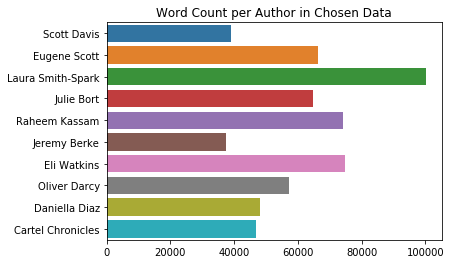

In [12]:
sns.barplot(x=lengths,y=names,orient='h')
plt.title('Word Count per Author in Chosen Data')
plt.show()

## 5.2 Turn Common Words into Features

**Approach**

Due to the curse of dimensionality, doing this step with all our 1,000 articles would take prohibitively long. (10 authors * 100 articles/ea = 1,000 articles)  At 30 seconds per article, my personal machine would need 8.5 hours of processing. Therefore I'll limit this part to 50 articles per author. This should still convey enough information for a decent predictive model.

**About 'Common Bag of Words'**

This technique consists of creating a feature out of each common word and then counting the number of times each common word appears in each article. Each cell will represent the number of times the lemma of the given column appears in the article of the current row. We have over 3,000 common words, and will be using 500 articles total. (50 per author) Plus each article may have a varying number of words in it. That's a lot of text to compare and count.

In [13]:
# check for lower case words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words:',len(common_words))
print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# Turn all common_words into lower case
common_words = [word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion):',np.sum([word.islower() for word in common_words]))

Count of all common_words: 3658
Count of lowercase common_words: 2352
Count of lowercase common_words (After Conversion): 3579


- Notice that after converting to lowercase the total number of lowercase words still isn't the same as the total. This means there are around 100 non alphabetic words inside our bag. This is probably made up of numbers and words with punctuations within.

# We must remove these in to avoid conflicts with existing features.
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

In [15]:
# Count the number of times a common_word appears in each article
# (about 3Hrs processing)

bow_counts = pd.DataFrame()
for name in names:
    # Select X articles of that author
    articles = authors_data.loc[authors_data.author==name,:][:50]
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

# Join BOW features with the author's content
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

# Fill the DataFrame with counts of each feature in each article
t0 = time()
for i, article in enumerate(bow_counts.content):
    doc = nlp(article)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every X articles
    if i % 50 == 0:
        if time()-t0 < 3600: # if less than an hour in seconds
            print("Article ",i," done after ",(time()-t0)/60,' minutes.')
        else:
            print("Article ",i," done after ",(time()-t0)/60/60,' hours.')

Article  0  done after  0.42328090270360313  minutes.
Article  50  done after  10.271135667959848  minutes.
Article  100  done after  24.337886516253153  minutes.
Article  150  done after  46.48636318047841  minutes.
Article  200  done after  1.094332391752137  hours.
Article  250  done after  1.3873678059710397  hours.
Article  300  done after  1.5501557772027121  hours.
Article  350  done after  1.805334949957  hours.
Article  400  done after  2.171408551865154  hours.
Article  450  done after  2.347395773132642  hours.


- This is the data that we can use to train clusters and classifiers. Each entry is an article, each column is a common word, and each cell is a count of the current common word in the current article.

In [16]:
bow_counts.head(3)

,title,content,author,becker,firm,dominate,russians,have,undermine,iran,...,hear,activity,room,federal,engine,newsweek,prioritize,entre,scorn,corker
0,A scramble for quarterbacks in the 2016 NFL Dr...,’ ’ ’ Two NFL teams enter the postseason st...,Scott Davis,0,0,0,0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rio’s Olympic Stadium has reportedly turned in...,’ ’ ” As is the case with many Rio’s Marac...,Scott Davis,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Grizzlies gambled on Chandler Parsons with...,’ ’ ’ Even in an NBA era with a rising sala...,Scott Davis,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


**Optional:**

- Store contents of `bow_counts`

In [17]:
# This saves the long-awaited data into a pickle file for easy recovery
#bow_counts.to_pickle('bow_counts')

# Read it back in with the following
#bow_counts = pd.read_pickle('bow_counts')

In [18]:
# Make sure we have 50 articles per author
bow_counts.author.value_counts()

Eli Watkins          50
Eugene Scott         50
Oliver Darcy         50
Raheem Kassam        50
Cartel Chronicles    50
Scott Davis          50
Jeremy Berke         50
Julie Bort           50
Daniella Diaz        50
Laura Smith-Spark    50
Name: author, dtype: int64

## 5.3. Clustering on BOW

[Back to Outline](#Outline)

- Before classifying, I'll start with clustering. Here I'll create clusters out of the BOW data and see if those clusters resemble the actual author's content. Clusters have no labels, but similar content tends to fall into the same clusters. Therefore in an ideal clustering solution, each author's articles would all fall into a single cluster.

In [19]:
# Establish outcome and predictors
y = bow_counts['author']
X = bow_counts.drop(['content','author','title'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)

In [20]:
# Make sure classes are balanced after train-test-split
y_test.value_counts()

Raheem Kassam        12
Julie Bort           12
Eli Watkins          12
Eugene Scott         12
Cartel Chronicles    12
Scott Davis          12
Jeremy Berke         12
Laura Smith-Spark    12
Oliver Darcy         12
Daniella Diaz        12
Name: author, dtype: int64

**DataFrame to Store our Results**

This `DataFrame` will hold results from all algorithms implemented ahead. For clustering algorithms, the train/test and cross_val columns will be left blank because clustering requires no train/test split. On the other hand, classifiers will inded store their own `ARI, Homogeneity, Silhouette, and Mutual_Info` scores. `Features` will represent the method for feature-engineering, whether BOW or LSA. And the `n_train` column will represent the number of samples in the train size.

In [21]:
# Store our results in a DataFrame
metrics = ['Algorithm','n_train','Features','ARI','Homogeneity',
           'Silhouette','Mutual_Info','Cross_Val','Train_Accuracy',
           'Test_Accuracy']
performance = pd.DataFrame(columns=metrics)

**Approach to Clustering**

In cluster analysis, there usually is no training or test data split. Because you do cluster analysis when you do not have labels, so you cannot "train".Training is a concept from machine learning, and train-test splitting is used to avoid overfitting. But if you are not learning labels, you cannot overfit. Properly used cluster analysis is a knowledge discovery method. You want to discover some new structure in your data, not rediscover something that is already labeled.

### 5.3.1. Unsupervised Parameter Search Function

[Back to Outline](#Outline)

- This function will find the parameters that produce the highest `Normalized Mutual Infomation` score from our clusters. This score is a good baseline from which to compare clustering VS classification because it correlates with good clutering as well as higher accuracy scores.
- It'll print the relevant statistics as well as a contingency matrix of the result and lastly store our results in an external DataFrame.

In [22]:
# Function to quickly evaluate clustering solutions
def evaluate_clust(clust,params,features,i):
    t0 = time()
    print('\n','-'*40,'\n',clust.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust,params,scoring=score,cv=3).fit(X,y)
    print("Best parameters:",search.best_params_)
    y_pred = search.best_estimator_.fit_predict(X)

    ari = adjusted_rand_score(y, y_pred)
    performance.loc[i,'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    hom = homogeneity_score(y,y_pred)
    performance.loc[i,'Homogeneity'] = hom
    print("Homogeneity Score: %.3f" % hom)
    
    sil = silhouette_score(X,y_pred)
    performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    nmi = normalized_mutual_info_score(y,y_pred)
    performance.loc[i,'Mutual_Info'] = nmi
    print("Normed Mutual-Info Score: %.3f" % nmi)
    
    performance.loc[i,'n_train'] = len(X)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clust.__class__.__name__
    
    # Print contingency matrix
    crosstab = pd.crosstab(y, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0,"seconds.")

### 5.3.2. KMeans CBOW

[Back to Outline](#Outline)


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 20, 'n_init': 20, 'precompute_distances': True}
Adjusted Rand-Index: 0.210
Homogeneity Score: 0.447
Silhouette Score: 0.050
Normed Mutual-Info Score: 0.428


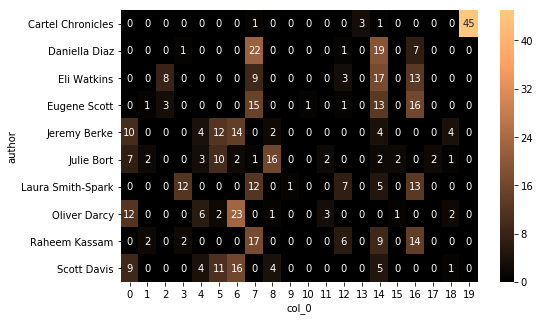

169.47527551651 seconds.


In [23]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='BOW',i=0)

### 5.3.3. Mean Shift CBOW

[Back to Outline](#Outline)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.002
Homogeneity Score: 0.101
Silhouette Score: 0.277
Normed Mutual-Info Score: 0.171


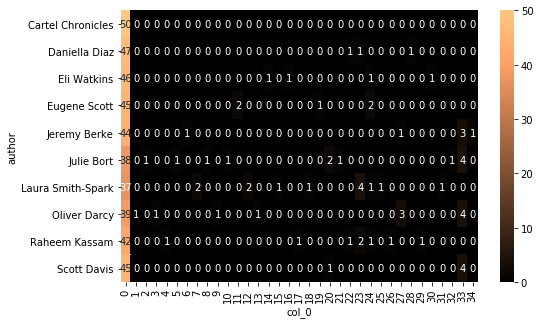

172.52272963523865 seconds.


In [24]:
#Declare and fit the model
clust = MeanShift()

params={}
evaluate_clust(clust,params,features='BOW',i=1)

- The above is a really bad solution. 30 clusters were created but most of our articles were assigned to the first cluster.

### 5.3.4. Affinity Propagation CBOW

[Back to Outline](#Outline)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best parameters: {'damping': 0.7, 'max_iter': 200}
Adjusted Rand-Index: 0.152
Homogeneity Score: 0.504
Silhouette Score: 0.044
Normed Mutual-Info Score: 0.432


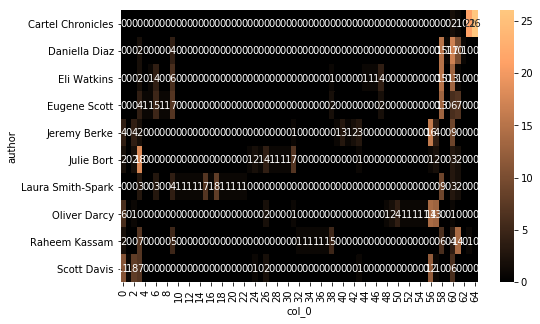

6.534716367721558 seconds.


In [25]:
#Declare and fit the model.
clust = AffinityPropagation()

params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='BOW',i=2)

- The above solution generated too many clusters to be properly visualized. However, the `Mutual_Info` score is quite decent because datapoints may be falling onto pockets that resemble the true labels.

### 5.3.5. Spectral Clustering CBOW

[Back to Outline](#Outline)

- SpectralClustering can't be used with GridSearchCV because it lacks a .fit method. Therefore I won't use the function here.

Adjusted Rand-Index: 0.000
Homogeneity Score: 0.012
Silhouette Score: -0.344
Normed Mutual-Info Score: 0.063


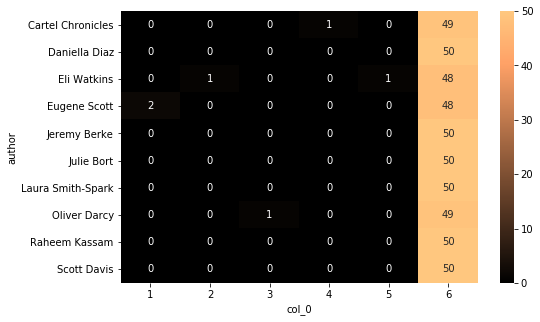

0.6043310165405273 seconds.


In [26]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='BOW'

i=3

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

In [27]:
performance.iloc[:,:7]

,Algorithm,n_train,Features,ARI,Homogeneity,Silhouette,Mutual_Info
0,KMeans,500,BOW,0.210114,0.446899,0.0498203,0.428272
1,MeanShift,500,BOW,0.00171957,0.101235,0.2766,0.17132
2,AffinityPropagation,500,BOW,0.151854,0.504396,0.0440665,0.431608
3,SpectralClustering,500,BOW,2.5954e-05,0.0120565,-0.344458,0.0632249


- Based on `Mutual_Info`, our highest score came from `AffinityPropagation`. However, the large number of clusters dividing our articles makes the solution a bit impractical.
- Fortunately we can perform supervised classification on this dataset because we actually do know who wrote these articles.

## 5.4. Classification on BOW

[Back to Outline](#Outline)

### 5.4.1. Supervised Parameter Search Function

- The following function will print cross-validation, train and test accuracy scores in addition to the clustering scores we've been utilizing previously.
- The `GridSearchCV` will also find the parameters that produce the highest `Normalized Mutual Information` score.
- There is a very clear correlation between the `Mutual_Info` score and the `Test_Accuracy` from our classifiers.
- Notice that here the `n_train` will be smaller than in the previous section because here we are actually doing a train/test split, whereas in the previous section we used `fit_predict(X)` on the clustering algorithms.

In [28]:
def score_optimization(clf,params,features,i):
    t0 = time()
    # Heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clf,params,
                          scoring=score,cv=3).fit(X,y)
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:",search.best_params_)

    # Cross-validate on all the data
    cv = cross_val_score(X=X,y=y,estimator=best,cv=5)
    print("\nCross-val scores(All Data):",cv)
    print("Mean cv score:",cv.mean())
    performance.loc[i,'Cross_Val'] = cv.mean() 
    
    # Get train accuracy
    best = best.fit(X_train,y_train)
    train = best.score(X=X_train,y=y_train)
    performance.loc[i,'Train_Accuracy'] = train 
    print("\nTrain Accuracy Score:",train)

    # Get test accuracy
    test = best.score(X=X_test,y=y_test)
    performance.loc[i,'Test_Accuracy'] = test 
    print("\nTest Accuracy Score:",test)
    
    y_pred = best.predict(X_test)
    
    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i,'ARI'] = ari 
    print("\nAdjusted Rand-Index: %.3f" % ari)
    
    hom = homogeneity_score(y_test,y_pred)
    performance.loc[i,'Homogeneity'] = hom
    print("Homogeneity Score: %.3f" % hom)
    
    sil = silhouette_score(X_test,y_pred)
    performance.loc[i,'Silhouette'] = sil
    print("Silhouette Score: %.3f" % sil)
    
    nmi = normalized_mutual_info_score(y_test,y_pred)
    performance.loc[i,'Mutual_Info'] = nmi
    print("Normed Mutual-Info Score: %.3f" % nmi)

    #print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    performance.loc[i,'n_train'] = len(X_train)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clf.__class__.__name__
    print(time()-t0,'seconds.')

### 5.4.2. Logistic Regression CBOW

[Back to Outline](#Outline)


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: {'C': 0.7, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-val scores(All Data): [0.79 0.78 0.74 0.82 0.65]
Mean cv score: 0.756

Train Accuracy Score: 1.0

Test Accuracy Score: 0.8416666666666667

Adjusted Rand-Index: 0.720
Homogeneity Score: 0.834
Silhouette Score: -0.002
Normed Mutual-Info Score: 0.838


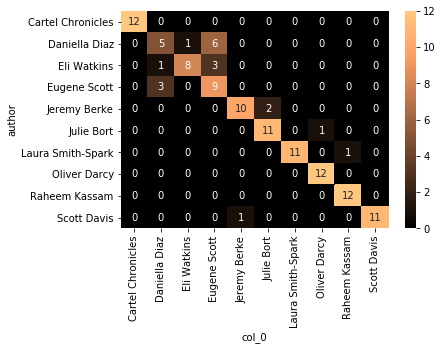

465.8297345638275 seconds.


In [29]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params,features='BOW',i=4)

- Although the clustering results didn't have a train/test or cross-validation score, here we have a `Mutual_Info` score around twice the highest of our clusters. Above, `Mutual_Info` was very close to `Accuracy`, just two percentage points away. As we get more solutions we'll see the consistency between `Mutual_Info` and `Accuracy` among other classifiers. This will allow us to assess classification and clustering solutions by a fair mutual metric.

### 5.4.3. Random Forest CBOW

[Back to Outline](#Outline)


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'gini'}

Cross-val scores(All Data): [0.78 0.82 0.73 0.83 0.7 ]
Mean cv score: 0.772

Train Accuracy Score: 1.0

Test Accuracy Score: 0.7916666666666666

Adjusted Rand-Index: 0.635
Homogeneity Score: 0.759
Silhouette Score: -0.050
Normed Mutual-Info Score: 0.763


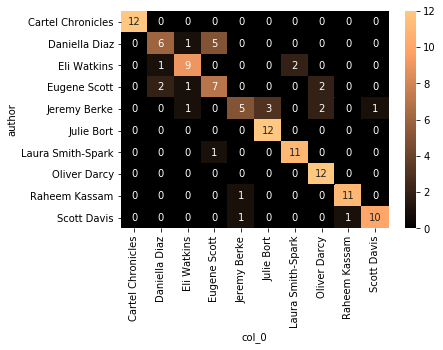

32.785361528396606 seconds.


In [30]:
# Parameters to compare
params = {
    'criterion':['entropy','gini'],
}

# Implement the classifier
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

score_optimization(clf=clf,params=params,features='BOW',i=5)

### 5.4.4. Gradient Boosting CBOW

[Back to Outline](#Outline)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: {'learning_rate': 0.3}

Cross-val scores(All Data): [0.74 0.77 0.72 0.79 0.67]
Mean cv score: 0.738

Train Accuracy Score: 1.0

Test Accuracy Score: 0.775

Adjusted Rand-Index: 0.598
Homogeneity Score: 0.742
Silhouette Score: -0.022
Normed Mutual-Info Score: 0.745


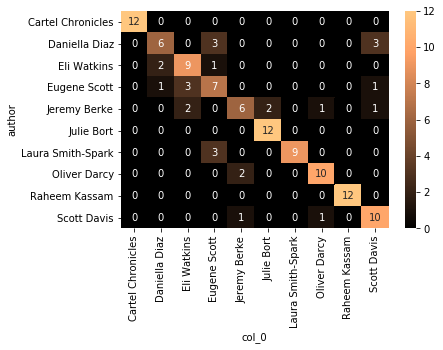

158.82711482048035 seconds.


In [31]:
# Parameters to compare
params = {
    'learning_rate':[0.3,0.5,0.7,1]
}

# Implement the classifier
clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf,params=params,features='BOW',i=6)

**Results**

- Clearly classifiers obtain higher scores than clustering, this is despite being trained with less data.
- So far `Accuracy` correlates perfectly with `Mutual_Info`.

In [32]:
performance.iloc[:7].sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']]

,Algorithm,n_train,Features,Mutual_Info,Test_Accuracy
4,LogisticRegression,380,BOW,0.837992,0.841667
5,RandomForestClassifier,380,BOW,0.762783,0.791667
6,GradientBoostingClassifier,380,BOW,0.744608,0.775
2,AffinityPropagation,500,BOW,0.431608,NaN
0,KMeans,500,BOW,0.428272,NaN
1,MeanShift,500,BOW,0.17132,NaN
3,SpectralClustering,500,BOW,0.0632249,NaN


# 6. Unsupervised Feature Generation

[Back to Outline](#Outline)


## 6.1. Latent Semantic Analysis

- Different from Bag-of-Words, Latent Semantic Analysis doesn't identify the most common words present in each article. Instead it identifies thematic components present in the text. Each cell doesn't contain a count, but rather a measure of how well a given feature is exemplified by the current document.

In [33]:
vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than X percent of documents
                             min_df=8, # only use words that appear at least X times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Pass pandas series to our vectorizer model
counts_tfidf = vectorizer.fit_transform(bow_counts.content)



- Notice that the content fed into the vectorizer is the same amount of data we used for BOW Counts. (500 articles in total, 50 by each author). We could use all of the 1000 articles, but first let's compare the LSA performance against BOW using the same data.
- The vectorizer returns a CSR Matrix which can then be reduced as in PCA.

In [34]:
counts_tfidf

<500x2537 sparse matrix of type '<class 'numpy.float64'>'
	with 60411 stored elements in Compressed Sparse Row format>

- Reducing to 460 features will retain 98% of the explained variance.

In [35]:
svd = TruncatedSVD(460)
svd.fit(counts_tfidf)
svd.explained_variance_ratio_.sum()

0.9859640295175764

In [36]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

(500, 460)

In [37]:
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

,0,1,2,3,4,5,6,7,8,9,...,450,451,452,453,454,455,456,457,458,459
0,0.134680,-0.089814,-0.126869,-0.076195,-0.029081,-0.048506,-0.178471,-0.246023,0.214692,-0.006315,...,-0.004800,-0.020942,0.013666,0.001285,-0.010951,-0.007190,-0.008646,0.019396,-0.019033,-0.007534
1,0.114785,-0.061037,-0.066941,-0.013864,0.027526,-0.048437,-0.012254,-0.015127,-0.030769,0.007581,...,-0.000458,0.002933,0.005627,0.010028,0.016389,0.004173,0.015980,0.010185,0.003076,-0.012193
2,0.111855,-0.089993,-0.123386,-0.087870,-0.030889,-0.047380,-0.150957,-0.226742,0.189297,0.005570,...,-0.002029,0.005429,-0.015806,0.008136,0.015794,-0.008042,0.011240,-0.003822,-0.004174,0.019684
3,0.095245,-0.089762,-0.090381,-0.076953,-0.007260,-0.075972,-0.205302,-0.271548,0.197548,0.007419,...,-0.019825,0.020571,-0.017085,0.003087,-0.018572,0.001156,0.010916,0.020293,0.017397,0.004179
4,0.071403,-0.056780,-0.076383,-0.049186,-0.022184,-0.048335,-0.125046,-0.123988,0.148768,0.009617,...,-0.013526,-0.014002,0.009156,-0.010148,-0.009235,-0.000538,0.001672,0.006391,0.024606,0.010571


## 6.2. Clustering on LSA (BOW Content)

- We'll repeat the clustering and classification, now using the LSA features from the same 500 articles we used in BOW Counts.

[Back to Outline](#Outline)

In [38]:
#First, establish X and Y
y = bow_counts['author']
X = lsa_data

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                   stratify=y)

In [39]:
y_test.value_counts()

Raheem Kassam        12
Julie Bort           12
Eli Watkins          12
Eugene Scott         12
Cartel Chronicles    12
Scott Davis          12
Jeremy Berke         12
Laura Smith-Spark    12
Oliver Darcy         12
Daniella Diaz        12
Name: author, dtype: int64

### 6.2.2. KMeans LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 20, 'n_init': 10, 'precompute_distances': True}
Adjusted Rand-Index: 0.336
Homogeneity Score: 0.534
Silhouette Score: 0.048
Normed Mutual-Info Score: 0.482


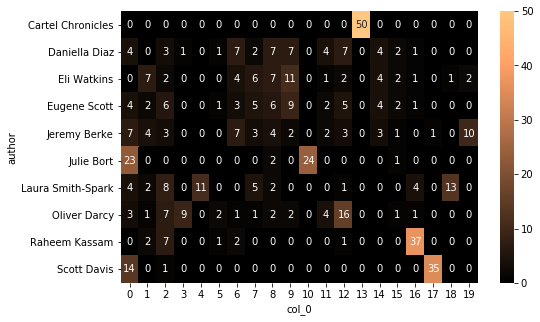

27.749962329864502 seconds.


In [40]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='LSA',i=7)

### 6.2.3. Mean Shift LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best parameters: {'bandwidth': 0.5}
Adjusted Rand-Index: 0.001
Homogeneity Score: 1.000
Silhouette Score: 0.010
Normed Mutual-Info Score: 0.609


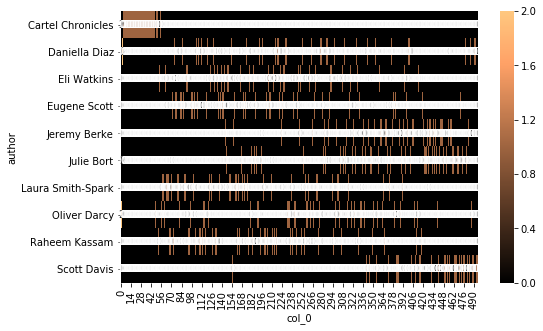

16.05977153778076 seconds.


In [41]:
#Declare and fit the model
clust = MeanShift()

params={
    'bandwidth':[0.5,0.7,0.9]
}
evaluate_clust(clust,params,features='LSA',i=8)

### 6.2.4. Affinity Propagation LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.110
Homogeneity Score: 0.689
Silhouette Score: 0.063
Normed Mutual-Info Score: 0.507


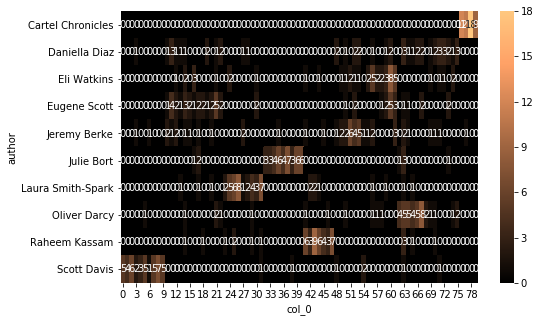

3.9195096492767334 seconds.


In [42]:
#Declare and fit the model.
clust = AffinityPropagation()

params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='LSA',i=9)

### 6.2.5. Spectral Clustering LSA

[Back to Outline](#Outline)

SpectralClustering can't be used with GridSearchCV because it lacks a .fit method. Therefore I won't use the function here.

Adjusted Rand-Index: 0.075
Homogeneity Score: 0.270
Silhouette Score: 0.040
Normed Mutual-Info Score: 0.369


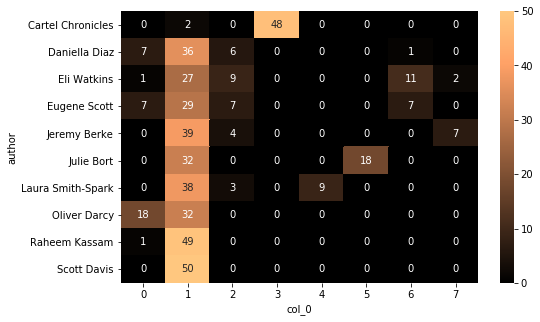

0.46030735969543457 seconds.


In [43]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='LSA'

i=10

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

**Results (See below)**

- Based on `Mutual_Info` score, classification outperforms clustering regardless of the method used for feature-generation.
- Within the clustering solutions however, LSA produced higher scores than BOW except for SpectralClustering.

In [44]:
performance.iloc[:11].sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']]

,Algorithm,n_train,Features,Mutual_Info,Test_Accuracy
4,LogisticRegression,380,BOW,0.837992,0.841667
5,RandomForestClassifier,380,BOW,0.762783,0.791667
6,GradientBoostingClassifier,380,BOW,0.744608,0.775
8,MeanShift,500,LSA,0.609241,NaN
9,AffinityPropagation,500,LSA,0.506508,NaN
7,KMeans,500,LSA,0.482019,NaN
2,AffinityPropagation,500,BOW,0.431608,NaN
0,KMeans,500,BOW,0.428272,NaN
10,SpectralClustering,500,LSA,0.368991,NaN
1,MeanShift,500,BOW,0.17132,NaN


## 6.3. Classification on LSA (BOW Content)

[Back to Outline](#Outline)

- Now we'll do supervised classification on the LSA features.

### 6.3.1. Logistic Regression LSA


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-val scores(All Data): [0.7  0.63 0.71 0.72 0.6 ]
Mean cv score: 0.6719999999999999

Train Accuracy Score: 0.9789473684210527

Test Accuracy Score: 0.7

Adjusted Rand-Index: 0.585
Homogeneity Score: 0.714
Silhouette Score: 0.048
Normed Mutual-Info Score: 0.724


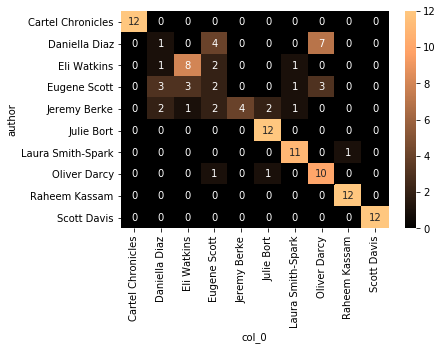

14.797184228897095 seconds.


In [45]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params,features='LSA',i=11)

### 6.3.2. Random Forest LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'entropy'}

Cross-val scores(All Data): [0.55 0.6  0.63 0.65 0.6 ]
Mean cv score: 0.606

Train Accuracy Score: 1.0

Test Accuracy Score: 0.6833333333333333

Adjusted Rand-Index: 0.538
Homogeneity Score: 0.691
Silhouette Score: 0.043
Normed Mutual-Info Score: 0.705


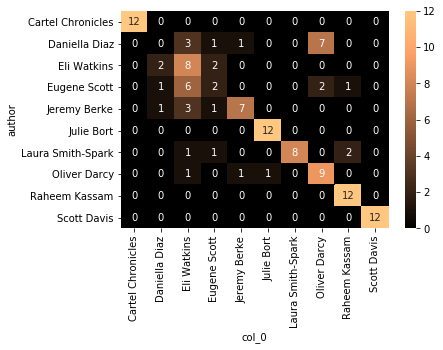

129.73267102241516 seconds.


In [46]:
# Parameters to compare
params = {
    'criterion':['entropy','gini'],
}

# Implement the classifier
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

score_optimization(clf=clf,params=params,features='LSA',i=12)

### 6.3.3. Gradient Boosting LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: {'learning_rate': 0.3}

Cross-val scores(All Data): [0.56 0.5  0.54 0.58 0.52]
Mean cv score: 0.54

Train Accuracy Score: 1.0

Test Accuracy Score: 0.6333333333333333

Adjusted Rand-Index: 0.444
Homogeneity Score: 0.602
Silhouette Score: 0.042
Normed Mutual-Info Score: 0.607


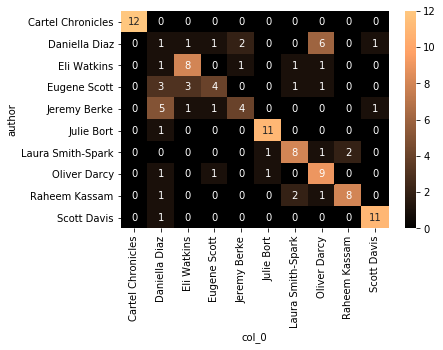

108.13380837440491 seconds.


In [47]:
# Parameters to compare
params = {
    'learning_rate':[0.3,0.5,0.7,1]
}

# Implement the classifier
clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf,params=params,features='LSA',i=13)

**Results**

- Once again, classification trumps clustering regardless of the feature-generation method. 
- BOW features have performed consistently better than LSA on all classifiers.

In [48]:
performance.iloc[:14].sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']].iloc[:9]

,Algorithm,n_train,Features,Mutual_Info,Test_Accuracy
4,LogisticRegression,380,BOW,0.837992,0.841667
5,RandomForestClassifier,380,BOW,0.762783,0.791667
6,GradientBoostingClassifier,380,BOW,0.744608,0.775
11,LogisticRegression,380,LSA,0.724234,0.7
12,RandomForestClassifier,380,LSA,0.705238,0.683333
8,MeanShift,500,LSA,0.609241,NaN
13,GradientBoostingClassifier,380,LSA,0.607244,0.633333
9,AffinityPropagation,500,LSA,0.506508,NaN
7,KMeans,500,LSA,0.482019,NaN


## 6.4. Clustering on LSA (All Content)

[Back to Outline](#Outline)

- Since LSA allows for very quick feature-generation, it's worth making a comparison between past results VS the utilization of all available data. After all, the LSA classifiers aren't far behind the BOW classifiers on 380 samples. With twice the number of articles LSA could very well outperform BOW. 

In [49]:
vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than X percent of documents
                             min_df=8, # only use words that appear at least X times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

#Pass pandas series to our vectorizer model
counts_tfidf = vectorizer.fit_transform(authors_data.content)



- Notice that this time we fed all the articles into the vectorizer. See the size of the CSR Matrix underneath. The 1000 rows are 100 articles for each 10 authors.

In [50]:
counts_tfidf

<1000x4141 sparse matrix of type '<class 'numpy.float64'>'
	with 129747 stored elements in Compressed Sparse Row format>

- This time we need 900 features to retain 98% of the variance.

In [51]:
svd = TruncatedSVD(900)
svd.fit(counts_tfidf)
svd.explained_variance_ratio_.sum()

0.983515568253816

In [52]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

(1000, 900)

In [53]:
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
0,0.095554,-0.077466,-0.088685,0.116715,-0.029071,0.229682,-0.093686,0.058752,0.031923,0.028790,...,-0.010506,0.001816,-0.010818,0.012826,0.001075,-0.003850,0.016747,0.021383,-0.005667,0.001116
1,0.077584,-0.042902,-0.065056,0.044378,0.013497,-0.008408,-0.020459,-0.026143,-0.014150,-0.002720,...,-0.011722,0.003748,-0.012560,0.002848,0.001334,0.003138,0.000326,0.003739,-0.000354,-0.029226
2,0.097580,-0.087290,-0.111300,0.132449,-0.040793,0.276451,-0.112235,0.081090,0.037374,0.025789,...,-0.005530,0.011339,0.000369,-0.002302,0.001701,-0.004557,0.017463,-0.004345,-0.018102,-0.011743
3,0.078344,-0.081317,-0.090485,0.133814,-0.014822,0.324981,-0.154498,0.116849,0.007485,0.040119,...,-0.002301,0.010314,0.004459,-0.000579,-0.007132,0.003670,0.002644,0.006324,0.020361,-0.004925
4,0.054085,-0.044813,-0.057238,0.071518,-0.018558,0.141139,-0.072288,0.014504,0.024686,0.022923,...,0.013553,-0.009679,-0.019383,0.013252,0.004278,0.011776,-0.008394,-0.006727,0.004344,-0.011744


In [54]:
#First, establish X and Y
y = authors_data['author']
X = lsa_data

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                   stratify=y)

- The test data reflects the change in size.

In [55]:
y_test.value_counts()

Raheem Kassam        24
Cartel Chronicles    24
Scott Davis          24
Jeremy Berke         24
Daniella Diaz        24
Eli Watkins          24
Eugene Scott         24
Julie Bort           24
Oliver Darcy         24
Laura Smith-Spark    24
Name: author, dtype: int64

### 6.4.1. KMeans LSA (All Content)

[Back to Outline](#Outline)


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best parameters: {'init': 'random', 'n_clusters': 10, 'n_init': 10, 'precompute_distances': True}
Adjusted Rand-Index: 0.246
Homogeneity Score: 0.463
Silhouette Score: 0.017
Normed Mutual-Info Score: 0.502


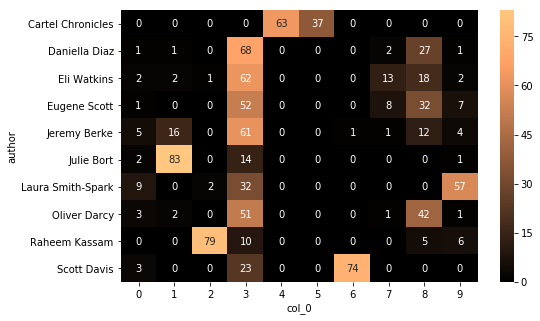

133.5461344718933 seconds.


In [56]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    'precompute_distances':[True,False]
}
evaluate_clust(clust,params,features='LSA',i=14)

### 6.4.2. Mean Shift LSA (All Content)

[Back to Outline](#Outline)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best parameters: {'bandwidth': 0.5}
Adjusted Rand-Index: 0.000
Homogeneity Score: 0.999
Silhouette Score: 0.004
Normed Mutual-Info Score: 0.577


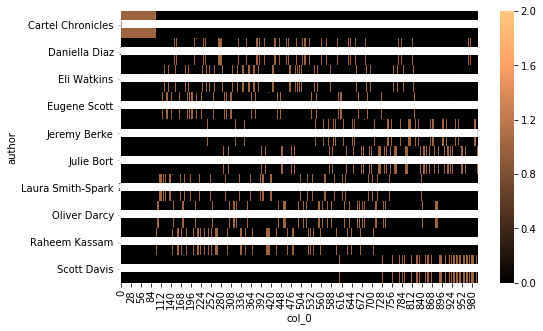

60.95715284347534 seconds.


In [57]:
#Declare and fit the model
clust = MeanShift()

params={
    'bandwidth':[0.5,0.7,0.9]
}
evaluate_clust(clust,params,features='LSA',i=15)

### 6.4.3. Affinity Propagation LSA (All Content)

[Back to Outline](#Outline)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.072
Homogeneity Score: 0.679
Silhouette Score: 0.055
Normed Mutual-Info Score: 0.467


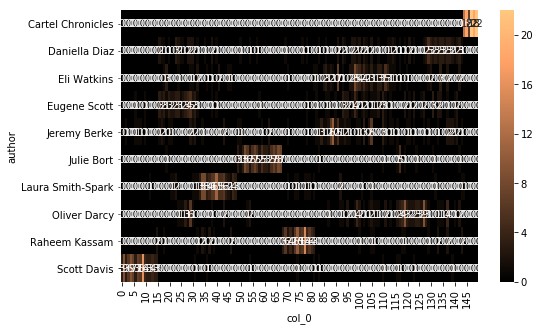

18.127511978149414 seconds.


In [58]:
#Declare and fit the model.
clust = AffinityPropagation()

params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
evaluate_clust(clust,params,features='LSA',i=16)

### 6.4.4. Spectral Clustering LSA (All Content)

[Back to Outline](#Outline)

SpectralClustering can't be used with GridSearchCV because it lacks a .fit method. Therefore I won't use the function here.

Adjusted Rand-Index: 0.125
Homogeneity Score: 0.335
Silhouette Score: 0.031
Normed Mutual-Info Score: 0.417


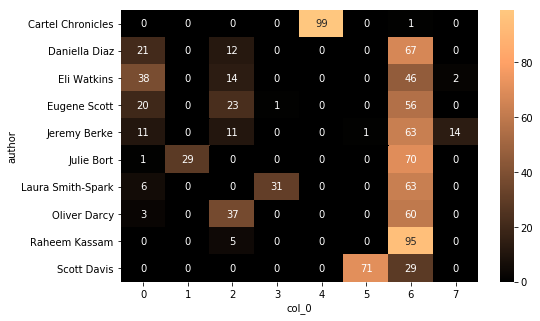

0.7042851448059082 seconds.


In [59]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='LSA'

i=17

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

## 6.5. Classification on LSA (All Content)

[Back to Outline](#Outline)

- We've done clustering on LSA using all 1000 articles. Now let's classify.

### 6.5.1. Logistic Regression LSA (All Content)


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-val scores(All Data): [0.66  0.68  0.705 0.695 0.62 ]
Mean cv score: 0.6719999999999999

Train Accuracy Score: 0.9631578947368421

Test Accuracy Score: 0.7583333333333333

Adjusted Rand-Index: 0.592
Homogeneity Score: 0.685
Silhouette Score: 0.030
Normed Mutual-Info Score: 0.687


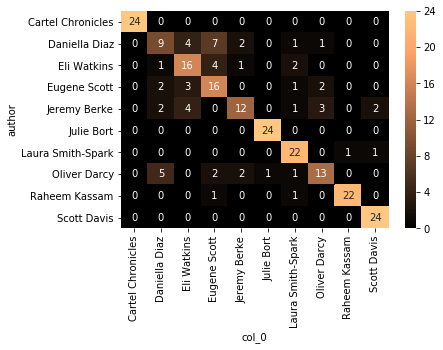

56.86849617958069 seconds.


In [60]:
# Parameters to optimize
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

clf = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

score_optimization(clf=clf,params=params,features='LSA',i=18)

### 6.5.2. Random Forest LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'entropy'}

Cross-val scores(All Data): [0.58  0.615 0.615 0.65  0.555]
Mean cv score: 0.603

Train Accuracy Score: 1.0

Test Accuracy Score: 0.6458333333333334

Adjusted Rand-Index: 0.481
Homogeneity Score: 0.589
Silhouette Score: 0.027
Normed Mutual-Info Score: 0.591


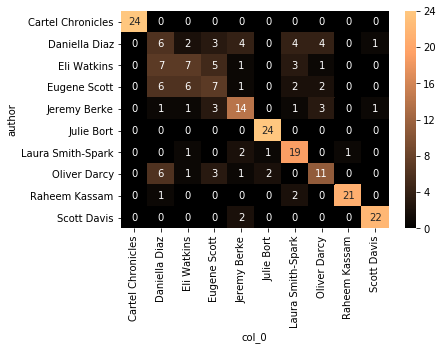

573.7529637813568 seconds.


In [61]:
# Parameters to compare
params = {
    'criterion':['entropy','gini'],
}

# Implement the classifier
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

score_optimization(clf=clf,params=params,features='LSA',i=19)

### 6.5.3. Gradient Boosting LSA

[Back to Outline](#Outline)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best parameters: {'learning_rate': 0.3}

Cross-val scores(All Data): [0.56  0.545 0.54  0.585 0.525]
Mean cv score: 0.5509999999999999

Train Accuracy Score: 1.0

Test Accuracy Score: 0.5625

Adjusted Rand-Index: 0.371
Homogeneity Score: 0.510
Silhouette Score: 0.026
Normed Mutual-Info Score: 0.512


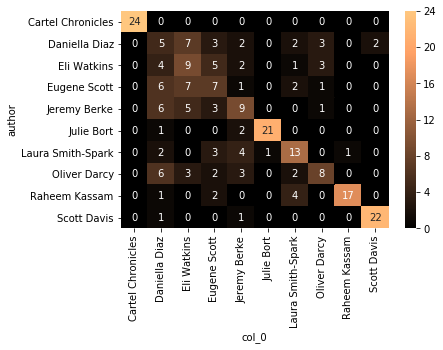

581.0574629306793 seconds.


In [62]:
# Parameters to compare
params = {
    'learning_rate':[0.3,0.5,0.7,1]
}

# Implement the classifier
clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf,params=params,features='LSA',i=20)

**Comparing Results:**

The results of more data are mixed with other methods. The LogisticRegression LSA with 760 samples is above GradientBoosting with 380, but below LogisticRegression with 380.
- **n_train**. Overal the 380 train size which is the 75% train split from the 500 BOW set generated higher scores than larger sizes.
- **Features**. Overall BOW features produced higher scores than most LSA features.
- **Supervised VS Unsupervised**. Classification produced indisputably  higher scores than clustering regardless of size or feature-generation .

In [65]:
performance.sort_values('Mutual_Info',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']].iloc[:10]

,Algorithm,n_train,Features,Mutual_Info,Test_Accuracy
4,LogisticRegression,380,BOW,0.837992,0.841667
5,RandomForestClassifier,380,BOW,0.762783,0.791667
6,GradientBoostingClassifier,380,BOW,0.744608,0.775
11,LogisticRegression,380,LSA,0.724234,0.7
12,RandomForestClassifier,380,LSA,0.705238,0.683333
18,LogisticRegression,760,LSA,0.687342,0.758333
8,MeanShift,500,LSA,0.609241,NaN
13,GradientBoostingClassifier,380,LSA,0.607244,0.633333
19,RandomForestClassifier,760,LSA,0.590879,0.645833
15,MeanShift,1000,LSA,0.577176,NaN


# 7. Choosing Model

[Back to Outline](#Outline)

## 7.1. Comparing Scores

- Since we tracked several scores throughout our testing, let's first compare our scores. The table below is sorted by `Mutual_Info` score.
-  The first three scores `Mutual_Info, ARI, Homogeneity` are most commonly used for clustering. `Cross_Val, Train_Accuracy, Test_Accuracy` are limited to classification. Therefore the `NaN` missing values are the clustering algorithms.
- Notice that `Mutal_Info` scores and `Test_Accuracy` are very closely related to one another. 
    - `Homogeneity` is close as well, but it gives 0.99 for index 15, which is a clustering algorithm with several dozens of clusters. Homogeneity will reward clustering solutions with numerous `n_clusters` because it penalizes clusters containing mixed true_labels. But so many clusters are practically useless.

In [68]:
performance.sort_values('Mutual_Info',ascending=False)[['Mutual_Info','ARI','Homogeneity','Cross_Val','Train_Accuracy','Test_Accuracy']].iloc[:10]

,Mutual_Info,ARI,Homogeneity,Cross_Val,Train_Accuracy,Test_Accuracy
4,0.837992,0.720231,0.834389,0.756,1,0.841667
5,0.762783,0.634581,0.759031,0.772,1,0.791667
6,0.744608,0.597551,0.741836,0.738,1,0.775
11,0.724234,0.584667,0.714154,0.672,0.978947,0.7
12,0.705238,0.538326,0.69103,0.606,1,0.683333
18,0.687342,0.592213,0.684947,0.672,0.963158,0.758333
8,0.609241,0.000588778,1,NaN,NaN,NaN
13,0.607244,0.444004,0.602122,0.54,1,0.633333
19,0.590879,0.480719,0.589479,0.603,1,0.645833
15,0.577176,6.87927e-05,0.999398,NaN,NaN,NaN


## 7.2. Sorting by Test_Accuracy

[Back to Outline](#Outline)

Although we established that `Mutual_Info` and `Test_Accuracy` are very closely aligned, if we sort by `Test_Accuracy` there is a slight difference in top performers.
- First of all, since clustering solutions have missing values they are all at the bottom.
- All the BOW solutions are still at the top.
- LogisticRegression 760 LSA is now above itself at 380 samples. For RandomForest however, less samples produced a higher test accuracy. Same goes for GradientBoosting underneath.

In [69]:
performance.sort_values('Test_Accuracy',ascending=False)[['Algorithm','n_train','Features','Mutual_Info','Test_Accuracy']].iloc[:10]

,Algorithm,n_train,Features,Mutual_Info,Test_Accuracy
4,LogisticRegression,380,BOW,0.837992,0.841667
5,RandomForestClassifier,380,BOW,0.762783,0.791667
6,GradientBoostingClassifier,380,BOW,0.744608,0.775
18,LogisticRegression,760,LSA,0.687342,0.758333
11,LogisticRegression,380,LSA,0.724234,0.7
12,RandomForestClassifier,380,LSA,0.705238,0.683333
19,RandomForestClassifier,760,LSA,0.590879,0.645833
13,GradientBoostingClassifier,380,LSA,0.607244,0.633333
20,GradientBoostingClassifier,760,LSA,0.512496,0.5625
0,KMeans,500,BOW,0.428272,NaN


## 7.3. Winner

[Back to Outline](#Outline)

**Algorithm** 

Clearly LogisticRegression has done a better job at predicting the author name regardless of other factors. Across varying train size and feature-generation, 3 out of the 5 top solutions are from LogisticRegression.

**Feature-Generation**

For the purposes of predicting author's names, classification on BOW features has outperformed LSA. However LSA could be more appropriate for other tasks. Perhaps an author's uniqueness is more palbable from his vocabulary than from the semantics of his writing. This may explain why BOW was superior in this project.

**Train_Size**

Train size produced dubious variations in LSA. More data helped LogisticRegression but made others less accurate. It would be nice to see the effects of Train size in BOW, but that takes a long time.

**Score**

Normalized Mutual Information is definitely the best score with which to compare clustering and classification algorithms. Other scores also also have a close resemblance, therefore I'd recommend to always compare several clustering scores.

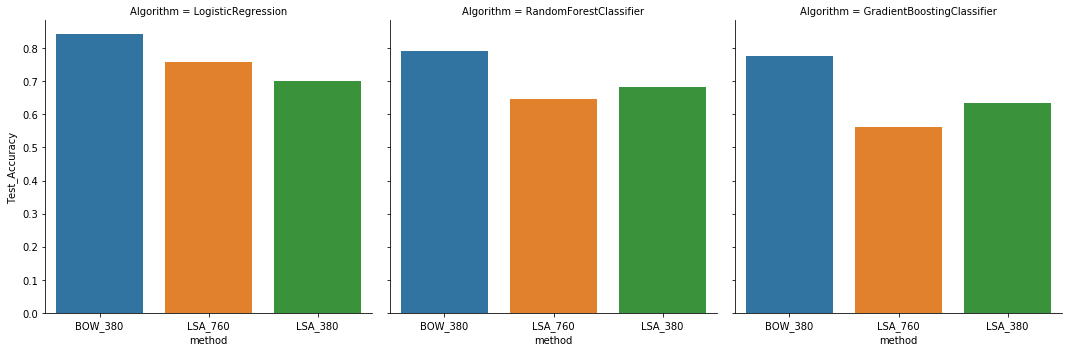

In [235]:
plot_data = performance.sort_values('Test_Accuracy',ascending=False)[['Algorithm','Features','n_train','Test_Accuracy']].iloc[:9]

plot_data.n_train = plot_data.n_train.apply(lambda x: str(x))
plot_data['method'] = plot_data.Features+'_'+plot_data.n_train
%matplotlib inline

sns.catplot(col='Algorithm',x='method',y='Test_Accuracy',
            data=plot_data,kind='bar')
plt.show()